# Задания

1. Выберите модель (UNet или DeepLabv3+).
2. Возьмите датасет (Carvana, Pascal VOC или Cityscapes subset).
3. Подготовьте данные и обучите модель сегментации.
4. Оцените качество с использованием IoU и Dice.
5. Визуализируйте результаты (картинки с наложением предсказанных масок).
6. Проведите эксперимент с разными размерами входного изображения или с аугментациями.

In [1]:
import os
from PIL import Image
import torch
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import VOCSegmentation

from tqdm import tqdm
import torch.nn as nn

from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore

import matplotlib.pyplot as plt
import numpy as np

# Задание 1-2

Используем датасет carvana и модель UNET. Тут классы для работы с датасетом/моделью

In [2]:
#класс для загрузки изображения и маски
#нужен для DataLoader
#DataLoader представляет собой итератор (iterable) над датасетом, который автоматически обрабатывает такие задачи, 
# как формирование батчей (группировка данных), перемешивание (shuffling), параллельную загрузку данных с 
# использованием нескольких процессов и даже оптимизацию памяти для работы с GPU.
#В общем очень удобная штука
class CarvanaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_transform=None, mask_transform=None):
        """
        images_dir: папка с jpg-картинками,
        masks_dir: папка с png-масками.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_ids = os.listdir(images_dir)
        self.img_transform = img_transform
        self.mask_transform = mask_transform


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        #img_path = os.path.join(f'{self.images_dir}/{img_id}')
        #mask_path = os.path.join(self.masks_dir, img_id.replace('.jpg', '_mask.png'))  # Исправлено для PNG-версии
        image = Image.open(f'{self.images_dir}/{img_id}').convert('RGB')
        mask = Image.open(f'{self.masks_dir}/{img_id.replace('.jpg', '_mask.gif')}').convert('L')  # маска: один канал
        # Применение трансформаций к изображению и маски
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()  # Бинарный тензор
        return image, mask

In [ ]:
#Класс для двойной свертки (два Conv2d + ReLU)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        #Создание последовательности слоев: Conv2d, ReLU, Conv2d, ReLU
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.seq(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        # Энкодер
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        # Боттлнек
        self.bottleneck = DoubleConv(512, 1024)
        # Декодер (с транспонированными свёртками для увеличения размерности)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(512+512, 512)  # +512 из пропуска
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(256+256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(128+128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(64+64, 64)
        # Финальный свёрточный слой: выдаём одно значение на пиксель
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Энкодер
        x1 = self.down1(x)            # выход 64 каналов
        x2 = self.down2(self.pool(x1))
        x3 = self.down3(self.pool(x2))
        x4 = self.down4(self.pool(x3))
        # Боттлнек
        xb = self.bottleneck(self.pool(x4))
        # Декодер с пропусками
        x = self.up4(xb)
        x = torch.cat([x4, x], dim=1)   # соединяем с соответствующим уровнем энкодера
        x = self.conv_up4(x)
        x = self.up3(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv_up3(x)
        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv_up2(x)
        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv_up1(x)
        x = self.final(x)
        return x

In [4]:
'''import zipfile

folders = ['train_masks.zip','train.zip','test.zip']
destination = ['train_mask','train','test']
def UnZipFile(path,dest):
    with zipfile.ZipFile(path,'r') as ref:
        ref.extractall(dest)

root = r'../carvana'

for path,dest in zip(folders,destination):
    print(f'=> Extracting {path}....')
    path = os.path.join(root,path)
    os.makedirs(dest,exist_ok=True)
    UnZipFile(path,dest)'''

"import zipfile\n\nfolders = ['train_masks.zip','train.zip','test.zip']\ndestination = ['train_mask','train','test']\ndef UnZipFile(path,dest):\n    with zipfile.ZipFile(path,'r') as ref:\n        ref.extractall(dest)\n\nroot = r'../carvana'\n\nfor path,dest in zip(folders,destination):\n    print(f'=> Extracting {path}....')\n    path = os.path.join(root,path)\n    os.makedirs(dest,exist_ok=True)\n    UnZipFile(path,dest)"

# Задание 3

In [9]:
# Трансформации (resize to 512x512 для памяти, original 1280x1918 too big)
# Отдельные трансформации
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])
# Датасет
full_dataset = CarvanaDataset(images_dir='./train/train', masks_dir='./train_masks/train_masks',
                              img_transform=img_transform, mask_transform=mask_transform)

print(f"Загружено {len(full_dataset)} примеров.")

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8,  shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8,  shuffle=False)

# Модель, loss, optimizer
model = UNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print('cuda' if torch.cuda.is_available() else 'cpu')
# Обучение (пример loop)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
num_epochs = 5  # пример
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):  # train_loader возвращает (batch,3,H,W) и (batch,1,H,W)
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)           # (batch,1,H,W) логиты
        loss = criterion(outputs, masks)  # поэлементная BCE
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Загружено 5088 примеров.
cuda


Epoch 1/5: 100%|██████████| 573/573 [03:18<00:00,  2.89it/s]


Epoch 1/5, Loss: 0.1233


Epoch 2/5: 100%|██████████| 573/573 [02:53<00:00,  3.30it/s]


Epoch 2/5, Loss: 0.0249


Epoch 3/5: 100%|██████████| 573/573 [02:52<00:00,  3.33it/s]


Epoch 3/5, Loss: 0.0193


Epoch 4/5: 100%|██████████| 573/573 [02:52<00:00,  3.32it/s]


Epoch 4/5, Loss: 0.0162


Epoch 5/5: 100%|██████████| 573/573 [03:04<00:00,  3.11it/s]

Epoch 5/5, Loss: 0.0130


In [62]:
torch.save(model.state_dict(), '256_UNet.pth')

# Задание 4

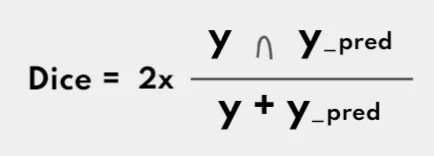

In [11]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

In [12]:
iou = JaccardIndex(task='binary').to(device)
dice = DiceScore(2).to(device)  # Binary by default
model.eval()
total_iou, total_dice = 0, 0
with torch.no_grad():
    for imgs, masks in tqdm(val_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        total_iou += iou(preds, masks)
        total_dice += dice_coefficient(preds, masks)
IoU = total_iou / len(val_loader)
Dice = total_dice / len(val_loader)
print(f'IoU: {IoU:.4f}, Dice: {Dice:.4f}')

100%|██████████| 64/64 [00:18<00:00,  3.52it/s]

IoU: 0.9787, Dice: 0.9892


In [34]:
images, masks = next(iter(val_loader)) 
print(len(masks))

8


# Задание 5

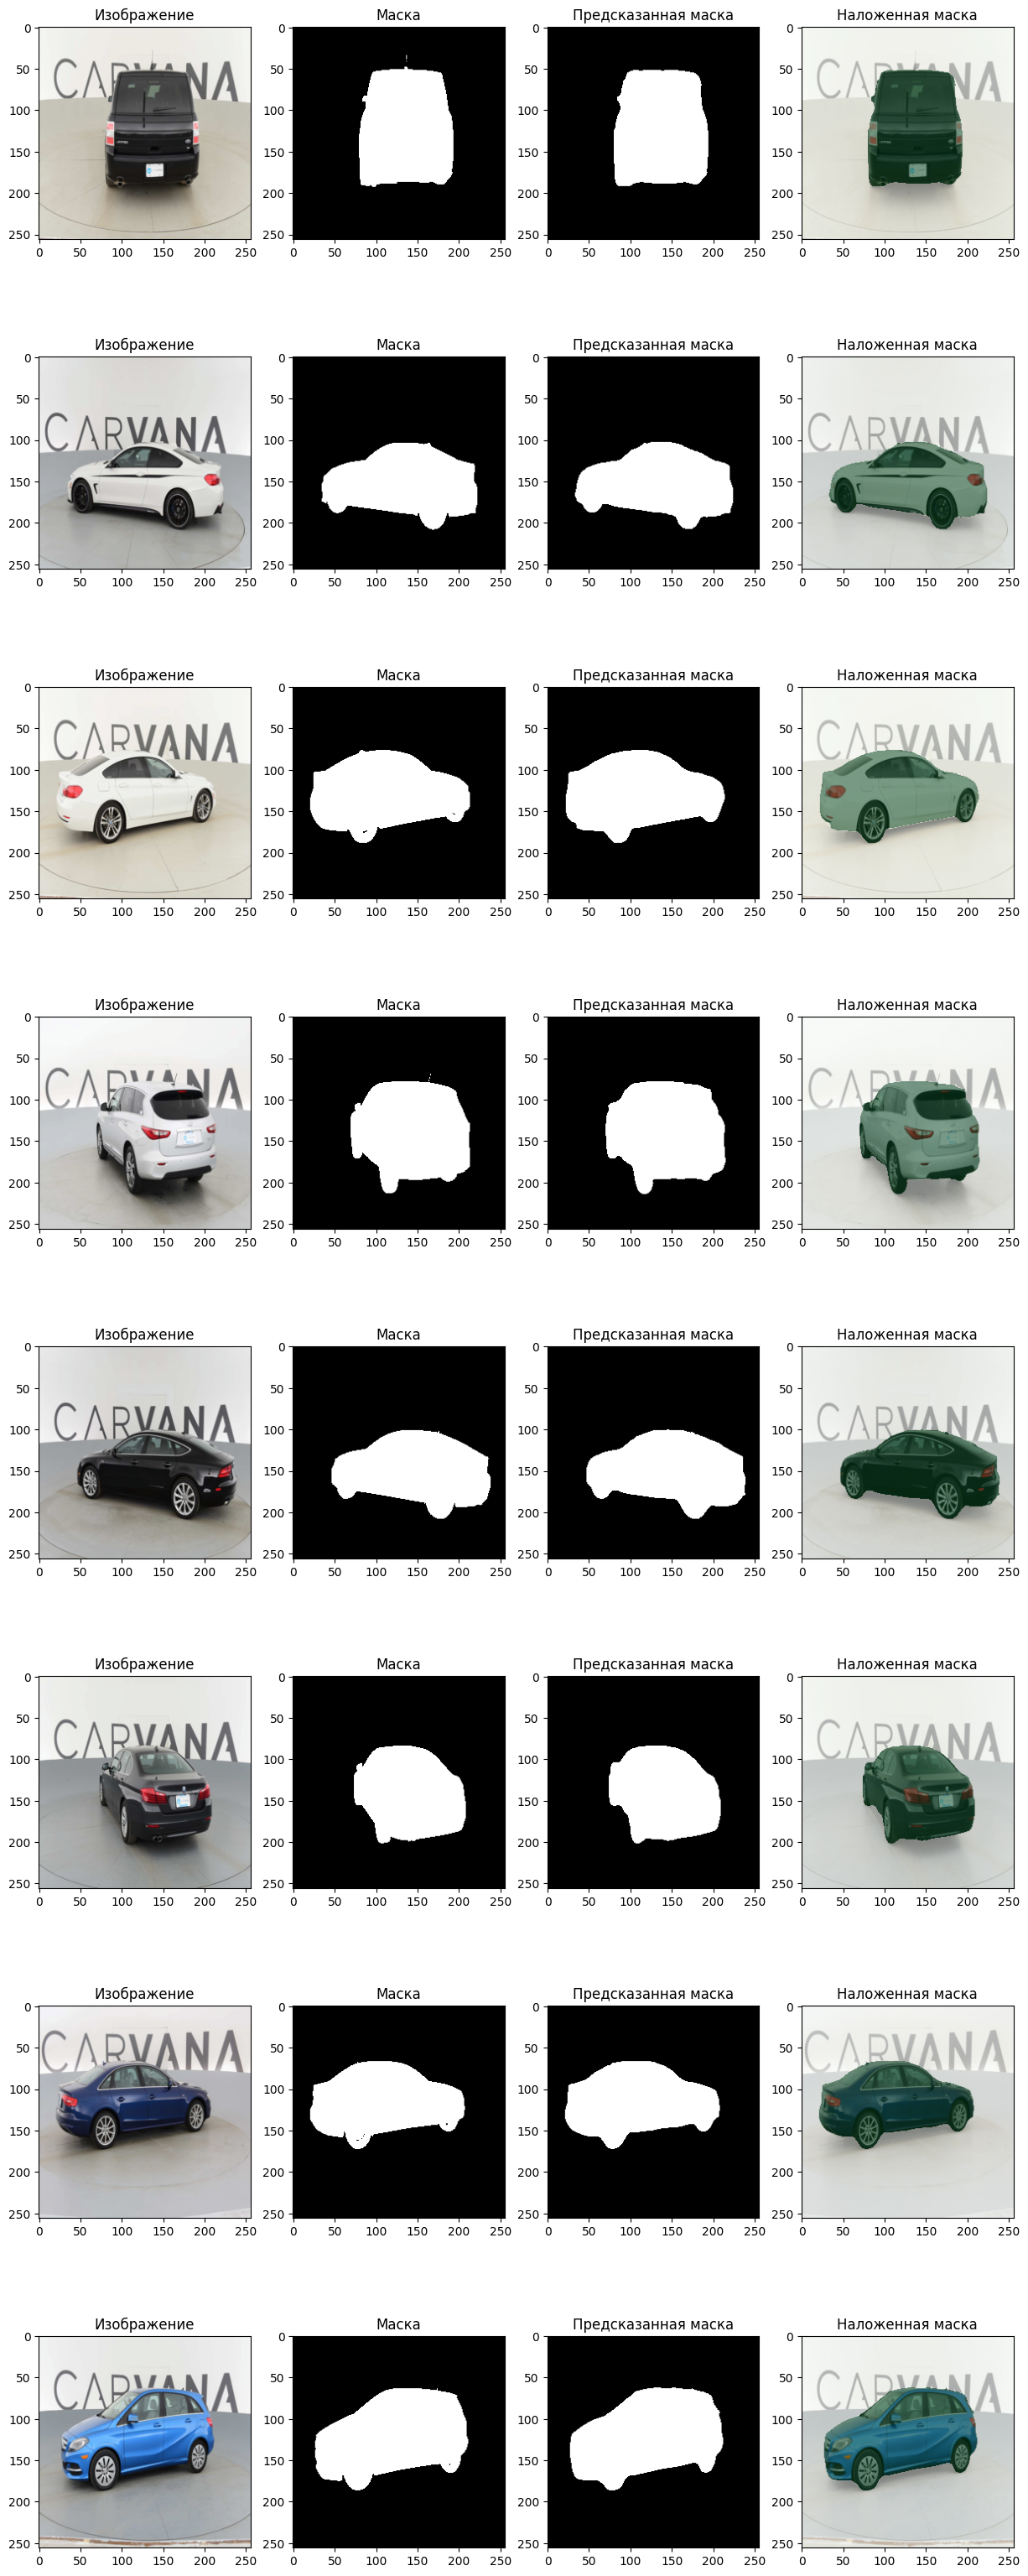

In [61]:
images, masks = next(iter(val_loader)) 
n_images = len(images)
fig, ax = plt.subplots(n_images, 4, figsize=(15, 5 * n_images))  # Одна фигура для всех изображений

for i in range(n_images):
    image = images[i].cpu()  
    mask = masks[i].cpu()   

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_denorm = np.transpose(image.numpy(), (1, 2, 0)) * std + mean
    img_denorm = np.clip(img_denorm, 0, 1)

    ax[i, 0].imshow(img_denorm)
    ax[i, 0].set_title('Изображение')
    ax[i, 1].imshow(mask.squeeze(0).numpy(), cmap='gray')  
    ax[i, 1].set_title('Маска')

    img_tensor = image.to(device).unsqueeze(0)
    pred = model(img_tensor)
    pred = (torch.sigmoid(pred) > 0.5).float().squeeze(0).squeeze(0).cpu().numpy()
    ax[i, 2].imshow(pred, cmap='gray')
    ax[i, 2].set_title('Предсказанная маска')

    ax[i, 3].imshow(img_denorm, cmap='gray')
    ax[i, 3].imshow(pred, cmap='Greens', alpha=0.5)
    ax[i, 3].set_title('Наложенная маска')
    
plt.show()


Задание 6 проводил в lab2.py, потому что ну долго модель обучается.